# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                  
Sample_077  P23083                                             15.817
Sample_170  O43300                                             15.467
Sample_166  E5RHU3;E5RJB8;E7ESK6;E9PBI9;P34741                 14.162
Sample_111  A6NG10;K7EIJ0;K7EIN1;K7EMC9;K7ENL2;K7ESN4;Q969T9   16.717
Sample_090  O76061                                             15.935
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                   
Sample_196  Q6UWP8                              11.941
Sample_015  Q504Y0;Q504Y0-3;Q504Y0-4;Q504Y0-5   10.958
Sample_161  Q86V85                              13.313
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.364
            A0A075B6Q5                 11.957
            A0A075B6R2                 14.025
            A0A075B6S5                 13.402
            A0A087WSY4                 11.728
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.478
            Q9UI40;Q9UI40-2            11.599
            Q9UIW2                     13.208
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.187
            Q9UP79                     11.526
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.998,15.050,16.842,19.863,15.919,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.732,19.067,...,15.528,15.576,14.009,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.816,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.134,17.705,17.039,15.685,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.535,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.425,15.345,17.084,18.708,14.249,19.433,11.861,11.035
Sample_207,15.739,16.877,15.469,16.898,15.010,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.364,...,16.012,15.178,12.224,15.050,16.842,19.863,14.022,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.309,19.067,16.188,...,15.528,15.576,11.739,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.011,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.844,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.089,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.377,15.345,17.084,18.708,14.249,19.433,10.584,13.013
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 376.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.29it/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

100%|██████████| 4/4 [00:00<00:00,  3.82it/s]

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.26it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.94it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.23it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.91it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.69it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.03it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.87it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.22it/s]

100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.33it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.64it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.97it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.62it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.44it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.40it/s]

100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.62it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.78it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.13it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.75it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.56it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.53it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:02<00:00,  2.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.66it/s]

 30%|███       | 3/10 [00:00<00:01,  4.71it/s]

 40%|████      | 4/10 [00:00<00:01,  4.09it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.63it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.28it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.05it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.96it/s]

100%|██████████| 10/10 [00:04<00:00,  1.97it/s]

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.58it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.70it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.43it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.21it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.96it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.92it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.00it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.08it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.18it/s]

100%|██████████| 11/11 [00:04<00:00,  2.42it/s]

100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.60it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.71it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.45it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.51it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.83it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.78it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.75it/s]

100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.77it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.58it/s]

 31%|███       | 4/13 [00:01<00:02,  3.05it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.90it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.98it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.93it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.72it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.39it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.31it/s]

100%|██████████| 13/13 [00:04<00:00,  2.31it/s]

100%|██████████| 13/13 [00:04<00:00,  2.73it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.32it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.97it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.12it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.91it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.50it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.32it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.21it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.15it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.28it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.52it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.26it/s]

 20%|██        | 3/15 [00:00<00:02,  4.33it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.39it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.56it/s]

 40%|████      | 6/15 [00:02<00:03,  2.36it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.19it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.10it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.41it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.55it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.62it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.65it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.68it/s]

100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.052 0.020          0.877 0.207       0.167   
2             0.004 0.003      0.051 0.017          0.657 0.103       0.570   
3             0.004 0.003      0.052 0.013          0.658 0.120       0.583   
4             0.004 0.003      0.061 0.022          0.712 0.101       0.636   
5             0.004 0.000      0.050 0.011          0.758 0.088       0.798   
6             0.004 0.003      0.061 0.021          0.782 0.093       0.817   
7             0.007 0.006      0.073 0.024          0.783 0.093       0.825   
8             0.006 0.005      0.068 0.023          0.793 0.085       0.829   
9             0.006 0.004      0.072 0.029          0.790 0.089       0.827   
10            0.004 0.003      0.053 0.016          0.794 0.084       0.820   
11            0.005 0.004      0.066 0.023          0.786 0.086       0.819   
12            0.006 0.004      0.069 0.025          0.795 0.080       0.812   
13            0.006 0.005      0.058 0.023          0.781 0.084       0.808   
14            0.006 0.005      0.065 0.025          0.779 0.080       0.805   
15            0.005 0.004      0.063 0.025          0.782 0.084       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.092   0.270 0.129                  0.575 0.045        0.858   
2          0.104   0.604 0.084                  0.674 0.062        0.729   
3          0.127   0.609 0.106                  0.676 0.078        0.765   
4          0.117   0.663 0.083                  0.719 0.064        0.807   
5          0.109   0.772 0.076                  0.804 0.065        0.887   
6          0.112   0.794 0.078                  0.823 0.068        0.889   
7          0.104   0.799 0.076                  0.827 0.066        0.886   
8          0.106   0.806 0.073                  0.834 0.063        0.907   
9          0.106   0.803 0.073                  0.831 0.063        0.905   
10         0.104   0.802 0.070                  0.831 0.060        0.904   
11         0.105   0.797 0.071                  0.826 0.061        0.902   
12         0.094   0.799 0.067                  0.828 0.058        0.909   
13         0.094   0.791 0.068                  0.820 0.058        0.909   
14         0.096   0.788 0.069                  0.818 0.058        0.908   
15         0.099   0.790 0.070                  0.819 0.061        0.906   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.827 0.087        210.000 0.000  
2          0.073                  0.662 0.089        210.000 0.000  
3          0.073                  0.692 0.093        210.000 0.000  
4          0.063                  0.769 0.084        210.000 0.000  
5          0.050                  0.860 0.063        210.000 0.000  
6          0.049                  0.862 0.059        210.000 0.000  
7          0.052                  0.857 0.063        210.000 0.000  
8          0.050                  0.893 0.055        210.000 0.000  
9          0.050                  0.893 0.055        210.000 0.000  
10         0.051                  0.891 0.056        210.000 0.000  
11         0.052                  0.888 0.057        210.000 0.000  
12         0.049                  0.902 0.049        210.000 0.000  
13         0.050                  0.902 0.050        210.000 0.000  
14         0.049                  0.901 0.049        210.000 0.000  
15         0.049                  0.899 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 470.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.12it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.90it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.38it/s]

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.16it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.88it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.81it/s]

100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.81it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.60it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.17it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.00it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.90it/s]

100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.92it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.04it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.54it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.25it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.11it/s]

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.06it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.74it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.88it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.82it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.49it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.39it/s]

 30%|███       | 3/10 [00:00<00:01,  3.99it/s]

 40%|████      | 4/10 [00:01<00:01,  3.46it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.22it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.34it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.06it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.92it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.06it/s]

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.78it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.73it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.44it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.29it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.03it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.03it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.15it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.20it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.27it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.73it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.33it/s]

 42%|████▏     | 5/12 [00:02<00:02,  2.40it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.42it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.44it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.43it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.38it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.34it/s]

100%|██████████| 12/12 [00:04<00:00,  2.47it/s]

100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.57it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.36it/s]

 31%|███       | 4/13 [00:01<00:03,  2.90it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.71it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.67it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.58it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.32it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.41it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.56it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.66it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.73it/s]

100%|██████████| 13/13 [00:04<00:00,  2.56it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.95it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.79it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.26it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.03it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.98it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.87it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.81it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.91it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.93it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.85it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.59it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.55it/s]

100%|██████████| 14/14 [00:04<00:00,  2.59it/s]

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.62it/s]

 20%|██        | 3/15 [00:00<00:03,  3.47it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.08it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.89it/s]

 40%|████      | 6/15 [00:01<00:03,  2.78it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.73it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.84it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.89it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.77it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.66it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.064 0.026          0.013 0.094       0.002   
2             0.005 0.004      0.060 0.021          0.676 0.117       0.465   
3             0.005 0.003      0.057 0.021          0.664 0.125       0.531   
4             0.006 0.004      0.072 0.030          0.766 0.105       0.688   
5             0.006 0.004      0.074 0.025          0.749 0.112       0.667   
6             0.004 0.002      0.048 0.005          0.760 0.108       0.683   
7             0.005 0.004      0.069 0.031          0.772 0.111       0.681   
8             0.009 0.008      0.085 0.038          0.759 0.111       0.710   
9             0.005 0.002      0.055 0.015          0.767 0.106       0.716   
10            0.005 0.003      0.054 0.015          0.746 0.104       0.699   
11            0.005 0.004      0.050 0.008          0.799 0.091       0.750   
12            0.005 0.003      0.054 0.015          0.807 0.080       0.818   
13            0.006 0.005      0.059 0.021          0.813 0.068       0.812   
14            0.005 0.004      0.058 0.018          0.809 0.070       0.812   
15            0.005 0.004      0.060 0.023          0.809 0.070       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.851   
2          0.123   0.541 0.104                  0.649 0.060        0.697   
3          0.123   0.581 0.099                  0.663 0.070        0.748   
4          0.120   0.717 0.090                  0.764 0.071        0.865   
5          0.114   0.700 0.096                  0.749 0.078        0.864   
6          0.109   0.713 0.085                  0.759 0.071        0.869   
7          0.120   0.715 0.086                  0.762 0.069        0.871   
8          0.122   0.727 0.093                  0.769 0.078        0.872   
9          0.125   0.733 0.093                  0.776 0.076        0.872   
10         0.129   0.714 0.093                  0.760 0.074        0.877   
11         0.118   0.769 0.086                  0.805 0.069        0.898   
12         0.114   0.808 0.079                  0.837 0.067        0.913   
13         0.110   0.808 0.075                  0.838 0.062        0.918   
14         0.111   0.806 0.076                  0.836 0.063        0.919   
15         0.111   0.806 0.076                  0.836 0.063        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.819 0.087        210.000 0.000  
2          0.079                  0.658 0.084        210.000 0.000  
3          0.072                  0.690 0.090        210.000 0.000  
4          0.059                  0.831 0.080        210.000 0.000  
5          0.061                  0.824 0.081        210.000 0.000  
6          0.060                  0.829 0.084        210.000 0.000  
7          0.062                  0.827 0.087        210.000 0.000  
8          0.064                  0.834 0.085        210.000 0.000  
9          0.064                  0.830 0.085        210.000 0.000  
10         0.059                  0.836 0.078        210.000 0.000  
11         0.056                  0.870 0.070        210.000 0.000  
12         0.048                  0.893 0.055        210.000 0.000  
13         0.047                  0.902 0.054        210.000 0.000  
14         0.047                  0.903 0.053        210.000 0.000  
15         0.047                  0.902 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 939.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.40it/s]

100%|██████████| 3/3 [00:00<00:00, 13.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.41it/s]

100%|██████████| 4/4 [00:00<00:00, 12.51it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.97it/s]

100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

100%|██████████| 5/5 [00:00<00:00, 13.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 12.46it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 10.56it/s]

100%|██████████| 6/6 [00:00<00:00, 10.05it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 17.50it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 13.15it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 10.95it/s]

100%|██████████| 7/7 [00:00<00:00, 11.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.71it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.94it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.84it/s]

100%|██████████| 8/8 [00:00<00:00, 12.61it/s]

100%|██████████| 8/8 [00:00<00:00, 12.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.85it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.68it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.91it/s]

100%|██████████| 9/9 [00:00<00:00, 12.96it/s]

100%|██████████| 9/9 [00:00<00:00, 13.84it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 29.40it/s]

 70%|███████   | 7/10 [00:00<00:00, 25.77it/s]

100%|██████████| 10/10 [00:00<00:00, 23.95it/s]

100%|██████████| 10/10 [00:00<00:00, 24.76it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 25.46it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 19.00it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 18.19it/s]

 91%|█████████ | 10/11 [00:00<00:00, 17.45it/s]

100%|██████████| 11/11 [00:00<00:00, 18.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 29.79it/s]

 50%|█████     | 6/12 [00:00<00:00, 23.87it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 23.11it/s]

100%|██████████| 12/12 [00:00<00:00, 23.05it/s]

100%|██████████| 12/12 [00:00<00:00, 23.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 29.41it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 25.77it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 22.30it/s]

100%|██████████| 13/13 [00:00<00:00, 22.66it/s]

100%|██████████| 13/13 [00:00<00:00, 23.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 30.75it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 25.10it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 23.26it/s]

100%|██████████| 14/14 [00:00<00:00, 23.23it/s]

100%|██████████| 14/14 [00:00<00:00, 23.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 28.50it/s]

 47%|████▋     | 7/15 [00:00<00:00, 23.46it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 22.08it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 22.47it/s]

100%|██████████| 15/15 [00:00<00:00, 22.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.058 0.024          0.000 0.000       0.000   
2             0.004 0.003      0.054 0.019          0.464 0.402       0.057   
3             0.005 0.004      0.051 0.022          0.674 0.124       0.521   
4             0.006 0.005      0.073 0.029          0.673 0.123       0.507   
5             0.006 0.005      0.070 0.030          0.669 0.123       0.511   
6             0.006 0.004      0.070 0.030          0.665 0.125       0.510   
7             0.004 0.002      0.047 0.008          0.647 0.136       0.492   
8             0.004 0.000      0.047 0.009          0.633 0.134       0.476   
9             0.003 0.002      0.032 0.012          0.635 0.129       0.501   
10            0.003 0.001      0.034 0.010          0.632 0.128       0.495   
11            0.003 0.002      0.032 0.011          0.635 0.120       0.500   
12            0.003 0.001      0.029 0.005          0.625 0.116       0.482   
13            0.003 0.001      0.030 0.006          0.654 0.106       0.566   
14            0.003 0.001      0.030 0.006          0.683 0.104       0.592   
15            0.003 0.001      0.031 0.006          0.692 0.094       0.610   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.712   
2          0.053   0.096 0.084                  0.510 0.027        0.559   
3          0.103   0.579 0.081                  0.662 0.060        0.733   
4          0.114   0.568 0.092                  0.658 0.063        0.728   
5          0.116   0.569 0.092                  0.658 0.062        0.721   
6          0.117   0.568 0.098                  0.657 0.069        0.716   
7          0.107   0.549 0.095                  0.641 0.071        0.705   
8          0.113   0.533 0.096                  0.630 0.070        0.698   
9          0.111   0.551 0.094                  0.639 0.070        0.694   
10         0.111   0.546 0.094                  0.636 0.069        0.690   
11         0.106   0.551 0.088                  0.640 0.066        0.685   
12         0.108   0.536 0.088                  0.631 0.063        0.677   
13         0.119   0.600 0.095                  0.672 0.073        0.716   
14         0.101   0.629 0.087                  0.694 0.069        0.747   
15         0.116   0.643 0.091                  0.705 0.067        0.766   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.679 0.071        210.000 0.000  
2          0.084                  0.513 0.084        210.000 0.000  
3          0.070                  0.674 0.089        210.000 0.000  
4          0.069                  0.672 0.088        210.000 0.000  
5          0.073                  0.664 0.092        210.000 0.000  
6          0.075                  0.652 0.098        210.000 0.000  
7          0.081                  0.642 0.101        210.000 0.000  
8          0.078                  0.637 0.098        210.000 0.000  
9          0.075                  0.637 0.096        210.000 0.000  
10         0.074                  0.633 0.094        210.000 0.000  
11         0.074                  0.626 0.095        210.000 0.000  
12         0.073                  0.621 0.097        210.000 0.000  
13         0.077                  0.682 0.088        210.000 0.000  
14         0.081                  0.712 0.089        210.000 0.000  
15         0.075                  0.730 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,8,5
score_time,7,8,4
test_precision,1,13,15
test_recall,8,12,15
test_f1,8,12,15
test_balanced_accuracy,8,13,15
test_roc_auc,12,14,15
test_average_precision,13,14,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.79it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.50it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.62it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.18it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.96it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.88it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.77it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.69it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  4.64it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.43it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.88it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.93it/s]

100%|██████████| 14/14 [00:03<00:00,  3.94it/s]

100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 28.90it/s]

 40%|████      | 6/15 [00:00<00:00, 24.38it/s]

 60%|██████    | 9/15 [00:00<00:00, 23.27it/s]

 80%|████████  | 12/15 [00:00<00:00, 22.78it/s]

100%|██████████| 15/15 [00:00<00:00, 22.08it/s]

100%|██████████| 15/15 [00:00<00:00, 22.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.37it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.36it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.15it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.94it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.91it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.99it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.05it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.01it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.08it/s]

100%|██████████| 12/12 [00:02<00:00,  5.07it/s]

100%|██████████| 12/12 [00:02<00:00,  5.19it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


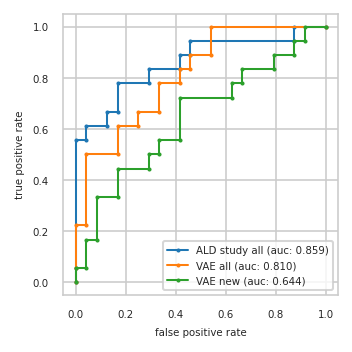

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.556   0.000 0.222   0.042 0.056
3          0.042 0.556   0.042 0.222   0.042 0.167
4          0.042 0.611   0.042 0.500   0.083 0.167
5          0.125 0.611   0.167 0.500   0.083 0.333
6          0.125 0.667   0.167 0.611   0.167 0.333
7          0.167 0.667   0.250 0.611   0.167 0.444
8          0.167 0.778   0.250 0.667   0.292 0.444
9          0.292 0.778   0.333 0.667   0.292 0.500
10         0.292 0.833   0.333 0.778   0.333 0.500
11         0.417 0.833   0.417 0.778   0.333 0.556
12         0.417 0.889   0.417 0.833   0.417 0.556
13         0.458 0.889   0.458 0.833   0.417 0.722
14         0.458 0.944   0.458 0.889   0.625 0.722
15         0.875 0.944   0.542 0.889   0.625 0.778
16         0.875 1.000   0.542 1.000   0.667 0.778
17         1.000 1.000   1.000 1.000   0.667 0.833
18           NaN   NaN     NaN   NaN   0.792 0.833
19           NaN   NaN     NaN   NaN   0.792 0.889
20           NaN   NaN     NaN   NaN   0.875 0.889
21           NaN   NaN     NaN   NaN   0.875 0.944
22           NaN   NaN     NaN   NaN   0.917 0.944
23           NaN   NaN     NaN   NaN   0.917 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P15086,P22676,Q9NUQ9
2,P01597;P04432,Q0P6D2,H0Y7T8;P49418;P49418-2
3,P61981,Q14894,Q96GD0
4,P04075,P63104,P31321
5,P14174,Q9Y2T3;Q9Y2T3-3,E9PK25;G3V1A4;P23528
6,C9JF17;P05090,P15151-2,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
7,P00338;P00338-3,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


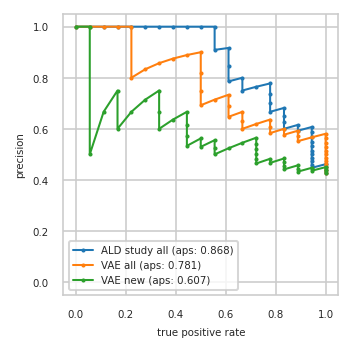

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.447 0.944     0.474 1.000     0.447 0.944
5          0.459 0.944     0.486 1.000     0.432 0.889
6          0.472 0.944     0.500 1.000     0.444 0.889
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.441 0.833
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.464 0.722
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.625 0.833     0.583 0.778     0.542 0.722
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.619 0.722     0.524 0.611
22         0.700 0.778     0.600 0.667     0.500 0.556
23         0.737 0.778     0.632 0.667     0.526 0.556
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.786 0.611     0.714 0.556     0.571 0.444
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


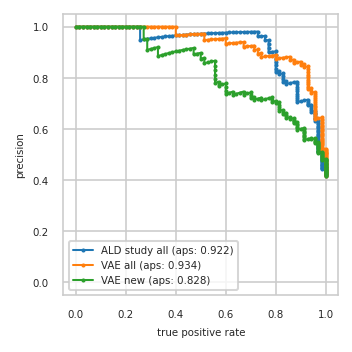

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


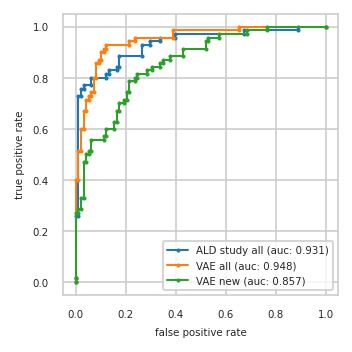

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}